In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# ML регрессия

В этом файле мы проверяли возможность предсказывать на основе нашего датафрейма разницу забитых мячей, между домашней и гостевой командой, поэтому тут реализована задача регрессии, так как нам показалось это более релевантным в данном случае.

In [2]:
match = pd.read_csv('match_ml.csv')

In [3]:
match.drop(columns='Unnamed: 0', inplace=True)

In [4]:
match.head()

,stage,height_hp1,weight_hp1,age_hp1,overall_rating_hp1,sprint_speed_hp1,gk_diving_hp1,gk_handling_hp1,gk_kicking_hp1,gk_positioning_hp1,...,age_ap11,overall_rating_ap11,dribbling_ap11,preferred_foot_right_ap11,pace_ap11,shooting_ap11,passing_ap11,defending_ap11,physical_ap11,goals_diff
0,1,185.42,183,21.0,68.0,43.0,72.0,63.0,71.0,64.0,...,20.0,62.0,67.45,0,71.60,49.75,55.65,31.5,47.35,2
1,1,187.96,181,21.0,69.0,27.0,69.0,65.0,66.0,69.0,...,24.0,62.0,59.15,1,63.20,64.60,61.55,35.2,70.25,-1
2,2,193.04,192,23.0,65.0,29.0,69.0,64.0,60.0,63.0,...,24.0,69.0,73.10,0,87.45,61.10,59.55,29.8,53.50,1
3,2,185.42,190,31.0,68.0,43.0,71.0,63.0,62.0,66.0,...,26.0,67.0,68.70,1,83.90,62.75,53.35,31.1,72.45,0
4,3,187.96,181,21.0,69.0,27.0,69.0,65.0,66.0,69.0,...,26.0,67.0,68.70,1,83.90,62.75,53.35,31.1,72.45,1


Разделим на тестовую и обучающую выборки:

In [5]:
y = match['goals_diff']
X = match.drop(columns=['goals_diff'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

In [6]:
def metrics(y_true, y_pred):
    return {'MSE': mean_squared_error(y_true, y_pred), 'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)}

## LinearRegression

Построим обычную линейную регрессию

In [16]:
linreg = LinearRegression()

In [17]:
linreg.fit(X_train, y_train)
lr_metric_train = metrics(y_train, linreg.predict(X_train))
lr_metric_test = metrics(y_test, linreg.predict(X_test))

In [22]:
print('Линейная регрессия на трейне:')
for name, value in lr_metric_train.items():
    print('{}: {}'.format(name, value))
print('Линейная регрессия на тесте:')
for name, value in lr_metric_test.items():
    print('{}: {}'.format(name, value))

Линейная регрессия на трейне:
MSE: 2.589936046636509
MAE: 1.2562447625710704
R2: 0.22512860266523071
Линейная регрессия на тесте:
MSE: 2.6157969421375156
MAE: 1.2759284388666883
R2: 0.17724513653185692


Видим, что скор R2 получается очень маленьким, а значит такая модель очень плохо предсказывает разницу мячей. Остальные скоры нас мало интересуют, так как неотскалированы, а значит слабо показывают нам как реально работает модель.

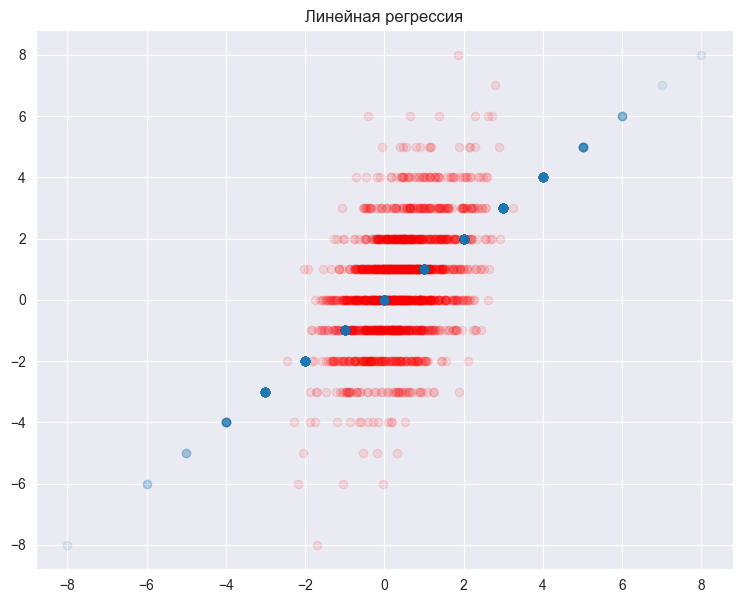

In [28]:
plt.figure(figsize=(9, 7))
plt.scatter(linreg.predict(X_test), y_test, color='red', alpha=0.1)
plt.scatter(y_test, y_test, alpha=0.1)

plt.title('Линейная регрессия')

plt.show()

## DecisionTreeRegressor

Построим дерево регрессии

In [9]:
dt = DecisionTreeRegressor()

In [10]:
gs = GridSearchCV(estimator=dt, param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 10, 20],
                                            'min_samples_split': np.arange(1, 10),
                                            'min_samples_leaf': np.arange(1, 20, 2)
                                            }, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 10, 20],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='neg_mean_squared_error')

In [11]:
best_params = gs.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 1}


In [12]:
best_dt = gs.best_estimator_

dt_metric_train = metrics(y_train, best_dt.predict(X_train))
dt_metric_test = metrics(y_test, best_dt.predict(X_test))

In [13]:
print('Линейная регрессия на трейне:')
for name, value in dt_metric_train.items():
    print('{}: {}'.format(name, value))
print('Линейная регрессия на тесте:')
for name, value in dt_metric_test.items():
    print('{}: {}'.format(name, value))

Линейная регрессия на трейне:
MSE: 2.8548957939400506
MAE: 1.3214488961540047
R2: 0.1458564793642736
Линейная регрессия на тесте:
MSE: 2.8365383274243876
MAE: 1.338535575054041
R2: 0.1078146523119845


К сожалению эта модель оказалась еще хуже.

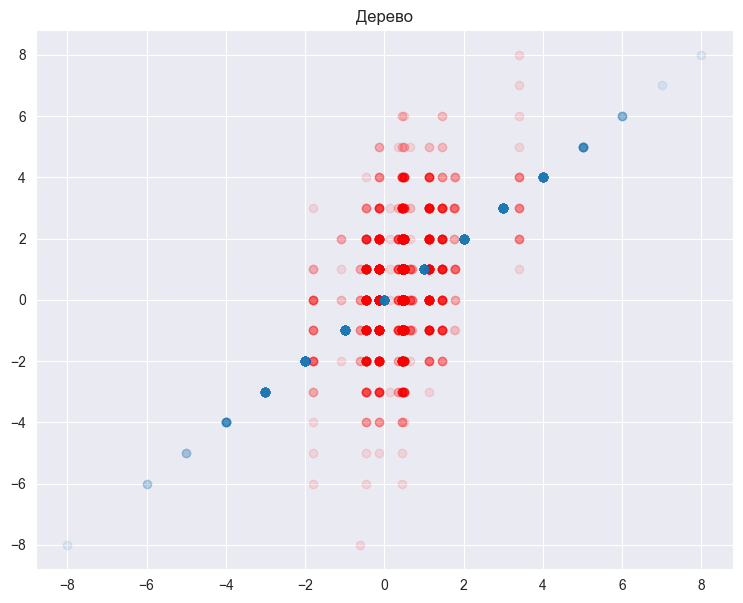

In [15]:
plt.figure(figsize=(9, 7))
plt.scatter(best_dt.predict(X_test), y_test, color='red', alpha=0.1)
plt.scatter(y_test, y_test, alpha=0.1)

plt.title('Дерево')

plt.show()

## XGBRF Regressor

In [32]:
xgbrf = XGBRFRegressor(learning_rate = 0.01, max_depth = 200, n_estimators = 3000)

In [34]:
xgbrf.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=200, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1500, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, ...)

In [35]:
xgbrf_metric_train = metrics(y_train, xgbrf.predict(X_train))
xgbrf_metric_test = metrics(y_test, xgbrf.predict(X_test))

In [36]:
print('Линейная регрессия на трейне:')
for name, value in xgbrf_metric_train.items():
    print('{}: {}'.format(name, value))
print('Линейная регрессия на тесте:')
for name, value in xgbrf_metric_test.items():
    print('{}: {}'.format(name, value))

Линейная регрессия на трейне:
MSE: 3.2867084864917953
MAE: 1.4141156730045585
R2: 0.016664368655981754
Линейная регрессия на тесте:
MSE: 3.1693419706745756
MAE: 1.4005249394322206
R2: 0.0031368726062483976


Лес же совсем не может ничему научиться и предсказывает константу, поэтому нами было принято решение перейти от задачи регрессии к задаче классификации.

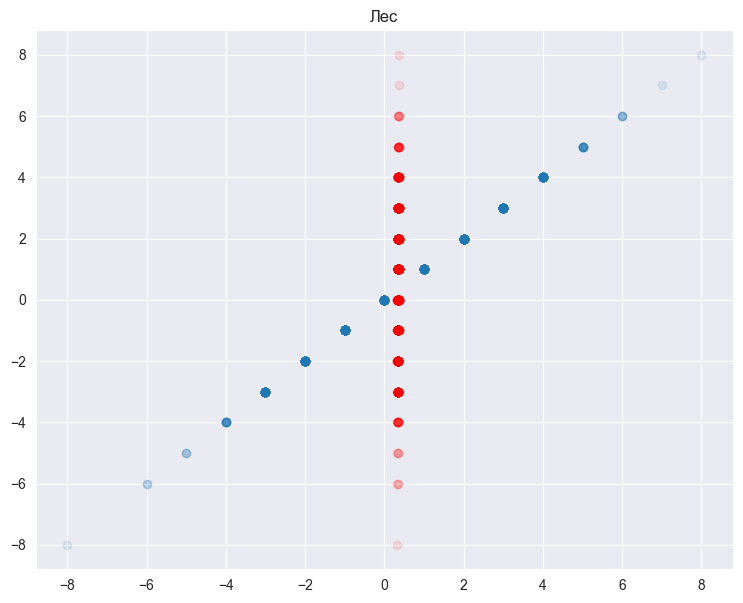

In [38]:
plt.figure(figsize=(9, 7))
plt.scatter(xgbrf.predict(X_test), y_test, color='red', alpha=0.1)
plt.scatter(y_test, y_test, alpha=0.1)

plt.title('Лес')

plt.show()